# ランダムウォークによる株価のシミュレーション

- ランダムウォークにより株式時系列データの簡単なシミュレーションを行う
- 「株式投資で元本割れを経験する割合が9割」という話を再現

## 前提

### ランダムウォーク

過程$y_t$が定数項$\delta$を用いて

$$
y_t=\delta+y_{t-1}+\varepsilon_t, \quad \varepsilon_t \sim \operatorname{iid}\left(0, \sigma^2\right)
$$

と表現されるとき、$y_t$はランダムウォークと呼ばれる。ただし、$y_0=0$とする。

ランダムウォークは代表的な単位根過程、すなわち、その差分系列が定常過程となる確率過程である。

## データ

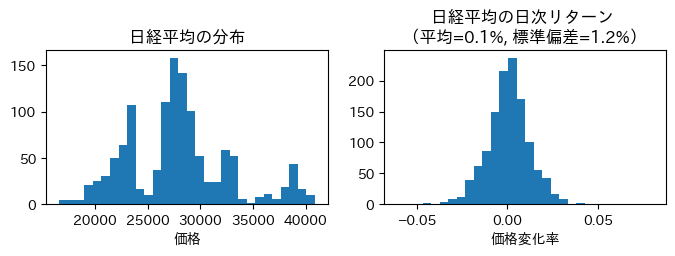

In [48]:
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import yfinance as yf

ticker = yf.Ticker("^N225")
df = ticker.history(period="5y")
prices = df["Close"]
returns = prices.pct_change(1)

fig, axes = plt.subplots(ncols=2, figsize=[8, 2])
axes[0].hist(prices, bins=30)
axes[0].set(xlabel="価格", title="日経平均の分布")

axes[1].hist(returns, bins=30)
axes[1].set(xlabel="価格変化率",
            title=f"日経平均の日次リターン \n（平均={returns.mean():.1%}, 標準偏差={returns.std():.1%}）")
fig.show()

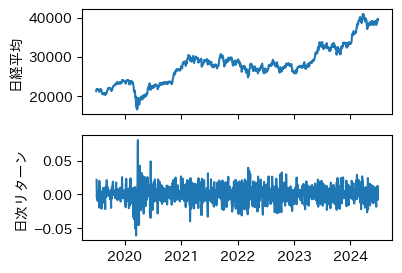

In [49]:
fig, axes = plt.subplots(nrows=2, figsize=[4, 3], sharex=True)
axes[0].plot(prices)
axes[0].set(ylabel="日経平均")
axes[1].plot(returns)
axes[1].set(ylabel="日次リターン")
fig.show()

ランダムウォークを10個生成するとつぎのようになる。

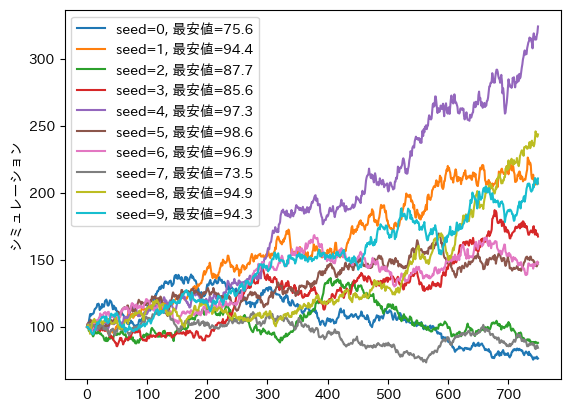

In [81]:
import numpy as np
base_price = 100

   
def gen_prices(seed, n = 250 * 3):
    np.random.seed(seed)
    returns_ = np.random.normal(loc=returns.mean(), scale=returns.std(), size=n)

    prev_price = base_price
    prices_ = [prev_price]
    for ret in returns_:
        price_ = prev_price * (1 + ret)
        prices_.append(price_)
        prev_price = price_
    return prices_

fig, ax = plt.subplots()
for seed in range(10):
    prices_ = gen_prices(seed)
    ax.plot(prices_, label=f"seed={seed}, 最安値={min(prices_):.1f}")
ax.set(ylabel="シミュレーション")
ax.legend()
fig.show()

## 元本割れが9割

もっと試行回数を増やし、最安値が初期値を下回った（元本割れした）率を計算する

In [87]:
import pandas as pd

results = []
for n_years in [1, 2, 5, 7, 10]:
    for seed in range(100):
        prices_ = gen_prices(seed, n=250*n_years)
        results.append({
            "期間（年数）": n_years,
            "元本割れ率": min(prices_) < base_price,
            "最安値": min(prices_),
            "最高値": max(prices_),
        })

pd.DataFrame(results).groupby("期間（年数）").mean().round(3)

,元本割れ率,最安値,最高値
期間（年数）,,,
1,0.96,91.099,125.397
2,0.96,89.854,145.098
5,0.96,88.286,233.708
7,0.96,88.192,330.347
10,0.96,88.175,487.246
